## Calculate SSH-based Gulf Stream Index using CMEMS satellite data 0.125 deg
### CMEMS product: Global Ocean Gridded L 4 Sea Surface Heights And Derived Variables Reprocessed 1993 Ongoing (Product ID: SEALEVEL_GLO_PHY_L4_MY_008_047; https://doi.org/10.48670/moi-00148)

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib import cm
import zhuomin_2new_tools

In [2]:
USER = os.environ['USER']

In [3]:
### satellite CMEMS SLA data
# Available from 1993.01 to 2023.12; checked on Jan. 27th, 2025
# Area range: 32°-51°N; 80-40°W
path = f'/glade/work/{USER}/MAPP/CMEMS/DATA'
filename = f'{path}/cmems_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.125deg_P1M-m_sla_199301-202312.nc'
ds = xr.open_dataset(filename)
sla = ds['sla'][:, :, :].values # 372, 152, 320
lat = ds['latitude'][:].values
lon = ds['longitude'][:].values
ds.close()
nmon, nlat, nlon = np.shape(sla)
smask = np.isnan(sla)
sla = np.ma.array(sla,mask=smask)
# monthly
sla_month = np.reshape(sla,[2024-1993,12,nlat,nlon])

### calculate Gulf Stream SSH-based main axis & SSH-based GSI

In [4]:
# calculate SSH max STD meridionally
sla_month_select = np.ma.reshape(sla_month[:2018-1993,:], [(2018-1993)*12, nlat, nlon]) # 1993-2018
sla_std_m = np.ma.std(sla_month_select, axis=0)

In [5]:
# obtain latitudinal positions that have the max std meridionally
lat_sla_max_std_m = np.ma.zeros(np.shape(sla_std_m)[1])
lat_sla_max_std_m.mask = True
#
for ii in range(np.shape(sla_std_m)[1]):
    lat_sla_max_std_m[ii] = lat[np.ma.argmax(sla_std_m[:, ii])]

In [6]:
# select points between 72°W and 52°W with 1° resolution
print(lon[67:250-29:8])
print(lat_sla_max_std_m[67:250-29:8])

[-71.5625 -70.5625 -69.5625 -68.5625 -67.5625 -66.5625 -65.5625 -64.5625
 -63.5625 -62.5625 -61.5625 -60.5625 -59.5625 -58.5625 -57.5625 -56.5625
 -55.5625 -54.5625 -53.5625 -52.5625]
[37.1875 37.4375 37.5625 37.6875 37.6875 37.9375 38.0625 38.0625 38.8125
 39.0625 39.4375 39.5625 39.4375 39.6875 39.8125 39.9375 39.8125 39.8125
 39.6875 39.5625]


In [7]:
# Etopo data
path = f'/glade/work/{USER}/MAPP/ETOPO'
filename = f'{path}/Etopo1_Bed_35_65N_40_80W.nc'
bathy = xr.open_dataset(filename)
lon_e = bathy['lon']
for ii in range(len(lon_e)):
    if lon_e[ii]>0:
        lon_e[ii] = lon_e[ii] - 360.
lat_e = bathy['lat'][:]
depth_e = bathy['depth'][:,:]
bathy.close()
#
mask_bathy = (depth_e >= 0.)*1.
mask_bathy = np.ma.array(mask_bathy,mask=mask_bathy==0.)
lon_e,lat_e = np.meshgrid(lon_e,lat_e)
lon_e = np.ma.array(lon_e,mask=~mask_bathy.mask)
lat_e = np.ma.array(lat_e,mask=~mask_bathy.mask)
depth_e1 = -np.ma.array(depth_e,mask=~mask_bathy.mask)

/glade/u/home/czhuomin/.conda/envs/fish-offline/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  """


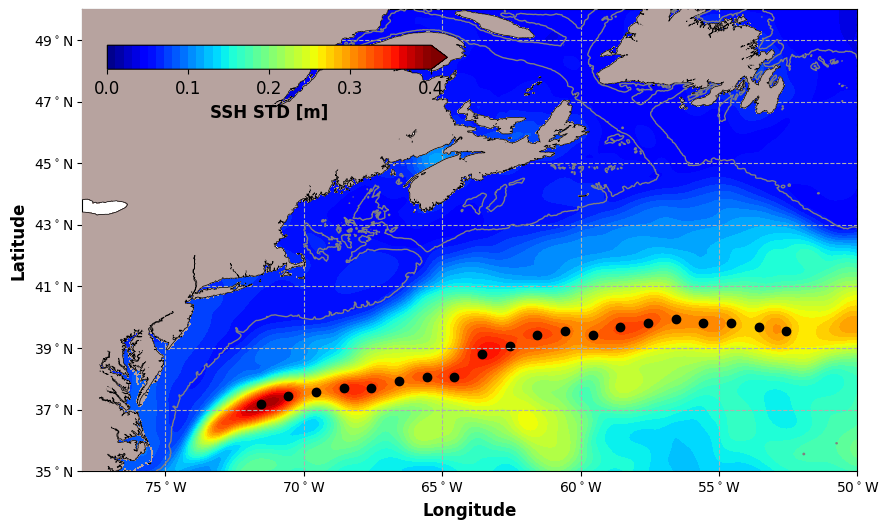

In [8]:
dlon,dlat = np.meshgrid(lon,lat)
fig = plt.figure(figsize=[10,6])
ax = fig.add_subplot(111)
# plot continent/bathymetry
ax.pcolor(lon_e,lat_e,mask_bathy,shading='nearest',cmap=cm.terrain_r,vmin=.5,vmax=4,zorder=20)
# plot coastal lines
ax.contour(lon_e,lat_e,depth_e,[0],colors='k',linestyles='solid',linewidths=.5,zorder=21)
# plot 200-m isobaths
ax.contour(lon_e,lat_e,depth_e,[-200],colors='gray',linestyles='solid',linewidths=1.,zorder=21)
#
cd = plt.contourf(dlon, dlat, sla_std_m, np.arange(0, .41, 0.01), cmap=cm.jet, extend='max')
plt.scatter(lon[67:250-29:8], lat_sla_max_std_m[67:250-29:8], color='k', marker='o')
#
ax.set_xticks(np.arange(-75,-49,5))
ax.set_xticklabels([r'%d$^\circ$W' % -ii for ii in np.arange(-75,-49,5)])
ax.set_yticks(np.arange(35,51,2))
ax.set_yticklabels([r'%d$^\circ$N' % ii for ii in np.arange(35,51,2)])
plt.ylabel('Latitude',fontsize=12,fontweight='bold')
plt.xlabel('Longitude',fontsize=12,fontweight='bold')
plt.xlim(-78,-50)
plt.ylim(35,50)
plt.grid(linestyle='dashed')
# colorbar
cbaxes = fig.add_axes([0.15, 0.78, 0.34, 0.04])
cb = plt.colorbar(cd,orientation="horizontal",cax=cbaxes,ticks=np.arange(0,0.41,.1))
cb.ax.tick_params(labelsize=12)
cb.set_label(label=r"SSH STD [m]",fontsize=12,fontweight='bold')
## save fig
output = f'/glade/work/{USER}/MAPP/CMEMS/PLOTS'
outfile = '%s/SSH-based_GSI_72-52W_199301-202312_monthly_points.png' % (output)
plt.savefig(outfile, dpi=400, facecolor='w', edgecolor='w', orientation='portrait')
#
plt.show()

In [9]:
# obtain index location for the selected points
sla_21_points = np.ma.zeros([len(lon[67:250-29:8]), 2024-1993, 12])
sla_21_points.mask = True
jj = 0
for ii in range(67, 250-29, 8):
    locx = np.where(lon == lon[ii])[0][0]
    locy = np.where(lat == lat_sla_max_std_m[ii])[0][0]
    sla_21_points[jj] = sla_month[:, :, locy, locx].copy()
    #
    jj = jj + 1
#
sla_21_points = sla_21_points.reshape([len(lon[67:250-29:8]), (2024-1993)*12])

In [10]:
# average the SLA across all the selected points
sla_21_points = sla_21_points.mean(axis=0)
# normalized the averaged SLA time series and obtain the SSH-based GSI
gsi_sla = (sla_21_points - sla_21_points.mean())/sla_21_points.std()

In [11]:
# save the SSH-based GSI
dsf = xr.Dataset()
dsf['GSI'] = gsi_sla
dsf.load()
# save to .nc file
outpath = f'/glade/work/{USER}/MAPP/CMEMS/DATA'
dsf.to_netcdf(f'{outpath}/SSH-based_GSI_72-52W_199301-202312_monthly.nc', mode='w')

In [12]:
# save to .csv file
yrmn = [list(np.arange(year+.01, year+.129, 0.01)) for year in range(1993, 2024)]
yrmn = ['%.2f' % j for sub in yrmn for j in sub]
data = {'year.month': yrmn,
        'SSH-based GSI': gsi_sla}
df = pd.DataFrame(data)
df.to_csv(f'{outpath}/SSH-based_GSI_72-52W_199301-202312_monthly.csv')

In [13]:
alist = ['%d' % ii for ii in range(1993,2025,2)]
blist = [' ' for ii in range(1993,2025,2)]
clist = np.array(list(zip(alist,blist))).flatten()
print(clist)

['1993' ' ' '1995' ' ' '1997' ' ' '1999' ' ' '2001' ' ' '2003' ' ' '2005'
 ' ' '2007' ' ' '2009' ' ' '2011' ' ' '2013' ' ' '2015' ' ' '2017' ' '
 '2019' ' ' '2021' ' ' '2023' ' ']


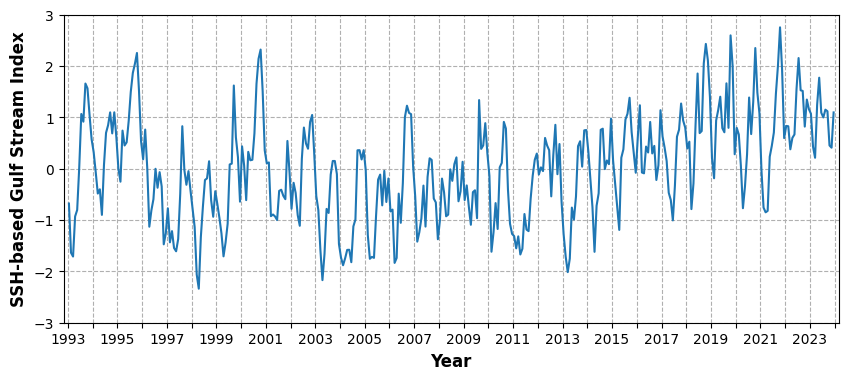

In [14]:
# plot the SSH-based GSI
fig = plt.figure(figsize=[10,4])
ax = fig.add_subplot(111)
ax.plot(np.arange(1993+1/24., 2024, 1/12.), gsi_sla, label='Satellite')
#ax.legend(loc=0,ncol=1)
ax.set_xlim(1992+10/12., 2024+2/12.)
ax.set_ylim(-3, 3)
ax.set_xticks(range(1993, 2025, 1))
ax.set_xticklabels(clist)
ax.set_ylabel('SSH-based Gulf Stream Index', fontsize=12, fontweight='bold')
ax.set_xlabel('Year', fontsize=12, fontweight='bold')
ax.grid(linestyle='dashed')
# save fig
output = f'/glade/work/{USER}/MAPP/CMEMS/PLOTS'
outfile = '%s/SSH-based_GSI_72-52W_199301-202312_monthly.png' % (output)
plt.savefig(outfile, dpi=400, facecolor='w', edgecolor='w', orientation='portrait')
#
plt.show()